# Part I: Bag of Words

In [1]:
#adapted from:
#https://github.com/sahilee26/IMDB-Movie-Reviews-Sentiment-Analysis/blob/master/Bag-of-words-random-forest.ipynb
#https://github.com/shiaoligreen/practical-data-science/tree/master/Bag%20of%20Words%20Meets%20Bags%20of%20Popcorn

# Load packages

#Generic tools
import re
import numpy as np
import os

#Data pre-preprocessing
import pandas as pd  
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords as nltkstopwords
import nltk.data

#Data split and featurization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#Random forest classifier and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

#Random forest visualization
import graphviz
from sklearn.tree import export_graphviz

#Multilayer Perceptron classifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification



In [2]:
# Load data
train = pd.read_csv("data/labeledTrainData.tsv", 
                    header=0, delimiter="\t", 
                    quoting=3)

test = pd.read_csv("data/testData.tsv", 
                   header=0, delimiter="\t",
                   quoting=3 )

unlabeled_train = pd.read_csv("data/unlabeledTrainData.tsv", header=0, 
                              delimiter="\t", quoting=3 )

# Split data to train and test partitions
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['sentiment']), 
                                                    train.sentiment, test_size=0.2)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [3]:
# Download text datasets, including stop words
nltk.download('stopwords', download_dir=os.environ['NOTEBOOK_ROOT'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/PZS0710/ejaffe/osc_classes/PEARC_HACKATHON...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords as nltkstopwords
print(nltkstopwords.words('english'))
#print(nltkstopwords.words('german'))
#print(nltkstopwords.words('chinese'))
#print(nltkstopwords.words.__dir__)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
def review_to_words(review, string=True, remove_stopwords=False):
    '''
    Function to convert a document to a sequence of words, 
    optionally removing stop words.  
    Returns a list of words.
    '''
    # Remove HTML
    review_text = BeautifulSoup(review).get_text()
    
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
    # Convert words to lower case and split them
    words = review_text.lower().split()
    
    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(nltkstopwords.words("english"))
        words = [w for w in words if not w in stops]
    if string:
        return " ".join(words)
    else:
        return words

In [6]:
# Can you select a single review (any random review) from the training data and pass it to review_to_words()?  What is the output?

# your code here
# get a single review from X_train
# print the review
# pass it as an argument to review_to_words()
# print the output


In [6]:
def review_to_bigrams(review, remove_stopwords=False, add_startend_tokens=True):
    '''
    Function to convert a document to a sequence of word bigrams,
    optionally removing stop words.
    Returns a list of bigrams.
    '''
    #E.g., ["I", "liked", "this" ,"movie"] -> ["I liked", "liked this", "this movie"]
    #your code here     
    
    # Remove HTML
    review_text = BeautifulSoup(review).get_text()
    
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
    # Convert words to lower case and split them
    words = review_text.lower().split()
    
    # Optionally add START and END tokens (True by default)
    if add_startend_tokens:
        words = ["START"] + words + ["END"]
        
    # Optionally remove stop words (False by default)
    if remove_stopwords:
        stops = set(nltkstopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    # Generate bigrams
    bigrams = []
    for i in range(len(words)-1):
        bigrams.append(words[i] + " " + words[i+1])

    return bigrams

#print(review_to_bigrams(["I", "liked", "this", "movie"]))
my_bigrams =review_to_bigrams("I liked this movie")
print(my_bigrams)

['START i', 'i liked', 'liked this', 'this movie', 'movie END']


In [7]:
# Get list of reviews
clean_train_reviews = [review_to_words(X_train["review"][i], remove_stopwords=True) for i in range(len(X_train))]
clean_test_reviews = [review_to_words(X_test["review"][i], remove_stopwords=True) for i in range(len(X_test))]

print(clean_train_reviews[0])

/fs/ess/PZS1142/PEARC_HACKATHON/jupyter/lib64/python3.6/site-packages/ipykernel_launcher.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  


rented movie falls genres romance western grand canyon scenery thrown expecting typical wholesome romantic western forget movie pure trash romance young girl even gone puberty middle aged man child also lusted leering men sickening peter fonda portrayed virtuous trying resist attraction brooke shields character mostly one pursues relationship tries shoo first eventually gives drive happy loving couple revolting see movie could appeal anyone except pedophiles


In [8]:
# Get lists of reviews using the bigram function instead of the review_to_words function

clean_train_bigram_reviews = [review_to_bigrams(X_train["review"][i]) for i in range(len(X_train))]
clean_test_bigram_reviews = [review_to_bigrams(X_test["review"][i]) for i in range(len(X_test))]

print(clean_train_bigram_reviews[0])

/fs/ess/PZS1142/PEARC_HACKATHON/jupyter/lib64/python3.6/site-packages/ipykernel_launcher.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  # This is added back by InteractiveShellApp.init_path()


['START i', 'i rented', 'rented this', 'this movie', 'movie because', 'because it', 'it falls', 'falls under', 'under the', 'the genres', 'genres of', 'of romance', 'romance and', 'and western', 'western with', 'with some', 'some grand', 'grand canyon', 'canyon scenery', 'scenery thrown', 'thrown in', 'in but', 'but if', 'if you', 'you re', 're expecting', 'expecting a', 'a typical', 'typical wholesome', 'wholesome romantic', 'romantic western', 'western forget', 'forget it', 'it this', 'this movie', 'movie is', 'is pure', 'pure trash', 'trash the', 'the romance', 'romance is', 'is between', 'between a', 'a young', 'young girl', 'girl who', 'who has', 'has not', 'not even', 'even gone', 'gone through', 'through puberty', 'puberty and', 'and a', 'a middle', 'middle aged', 'aged man', 'man the', 'the child', 'child is', 'is also', 'also lusted', 'lusted after', 'after by', 'by other', 'other leering', 'leering men', 'men it', 'it s', 's sickening', 'sickening peter', 'peter fonda', 'fond

In [9]:
# Initialize a bag of words  
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) #vocabulary size defined here, sorted by frequency - e.g., 5k most common terms.  How does model performance change if you increase/decrease this value?

# Fit transform the data
train_feat = vectorizer.fit_transform(clean_train_reviews).toarray()
test_feat = vectorizer.transform(clean_test_reviews).toarray()

In [11]:
# Take a look at the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab[:100])

['abandoned', 'abc', 'abilities', 'ability', 'able', 'abrupt', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abusive', 'abysmal', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'accompanied', 'accomplished', 'according', 'account', 'accurate', 'accused', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activities', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'ad', 'adam', 'adams', 'adaptation', 'adapted', 'add', 'added', 'adding', 'addition', 'adds', 'adequate', 'admire', 'admit', 'admittedly', 'adolescent', 'adorable', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'adventures', 'advertising', 'advice', 'advise', 'affair', 'affect', 'affected', 'affection', 'afford', 'aforementioned', 'afraid', 'africa', 'african', 'afternoon', 'afterwards', 'age', 'aged', 'agenda', 'agent', 'agents', 'ages', 'aging', '

In [12]:
# Random Forest Classifier Overview
#
# Improved performance variant of Decision Tree Learning, a supervised learning algorithm
#
# https://en.wikipedia.org/wiki/Decision_tree_learning#/media/File:Decision_Tree.jpg
#
# Decision trees are ways of taking input, and then moving left or right depending on your input and coming to a final decision, kind of like turn-by-turn instructions.
#
# For example, passenger survival on the Titanic can be predicted (not perfectly!) using features like sex and age.  Deciding which features and values to put where in the tree comes from taking measurements on the training data.
#
# Some features and values are better at splitting the output into the target predictions than others.  For example, wearing brown clothes vs. wearing black clothes is probably not very predictive of whether passengers survived or not, whereas age appears to be more predictive.
# 
# Let's imagine that one of the nodes in the tree is clothing color.  If you put all the data through the node, the two children nodes resulting from black or brown clothes would likely have something like 50% died and 50% survived, that is, clothing color doesn't separate the people into the target categories very well.
#
# On the other hand, for a node like 'age', being a child or adult could have 90/10 split for children surviving and 20/80 split for adults surviving.  This is a better decision to make when predicting survival because there is higher 'purity' in the outcomes - they're more skewed toward a category of interest than a simple 50/50 split.
#
# This ability to differentiate, or selectivity, is called 'information gain' and can be measured mathematically a few ways.

In [12]:
# Get predictions
def get_preds(test_feat, train_feat, y_test, y_train, model, title='Random Forest'):
    print("Training model, this may take some time...")
    model.fit(train_feat, y_train)
    
    print("Evaluating model...")
    y_preds = model.predict(test_feat)
    
    accuracy = accuracy_score(y_test, y_preds)
    print("Accuracy:", accuracy)

    #fpr, tpr, _ = roc_curve(y_test, preds)
    #roc_auc = auc(fpr, tpr)
    #print('AUC:', roc_auc)
    
    #F1 doesn't matter because of class balance here
    
    # plot AUC
    #plt.plot(fpr, tpr)
    #plt.title(title)
    #plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.show()
    
    return y_preds, model

In [13]:
preds_rf, model = get_preds(test_feat, train_feat, 
                  y_test, y_train, 
                  RandomForestClassifier(n_estimators = 100)) #How does performance changes if you increase/decrease the number of estimators (trees)?

Training model, this may take some time...
Evaluating model...
Accuracy: 0.8404


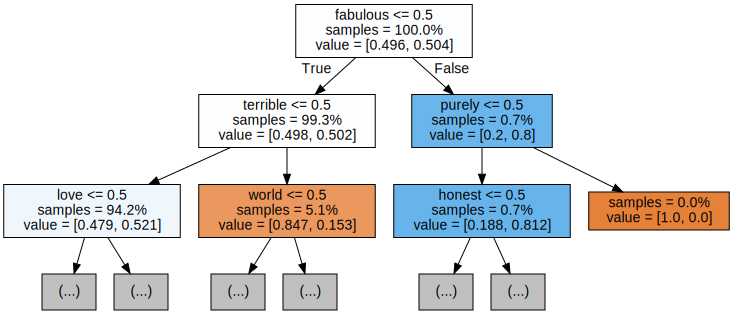

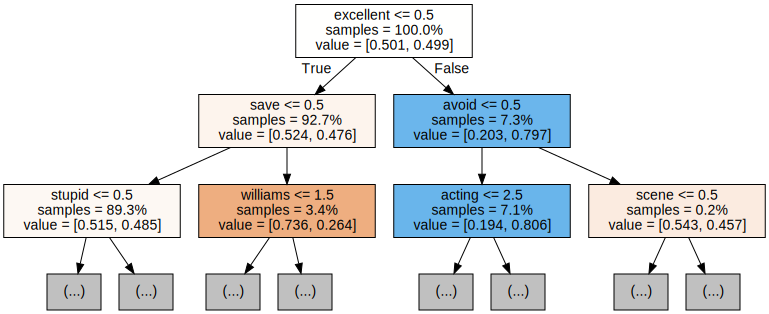

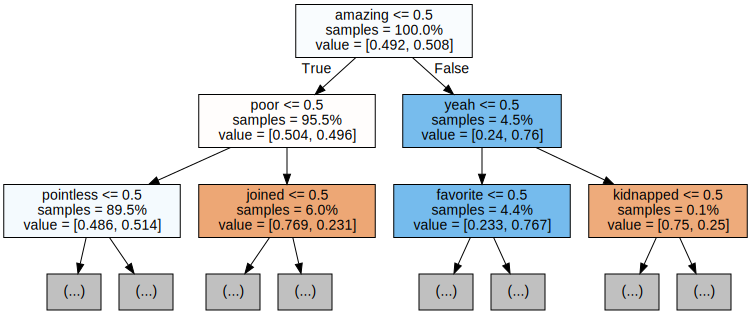

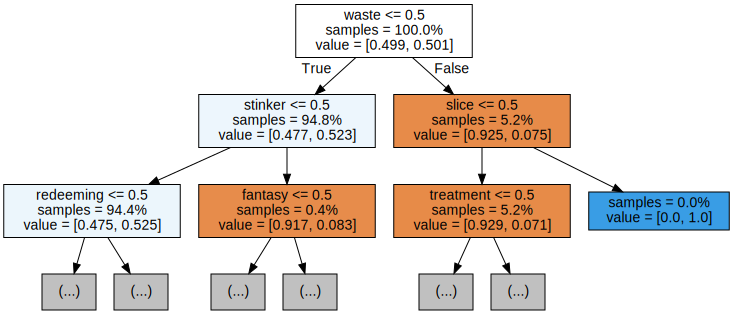

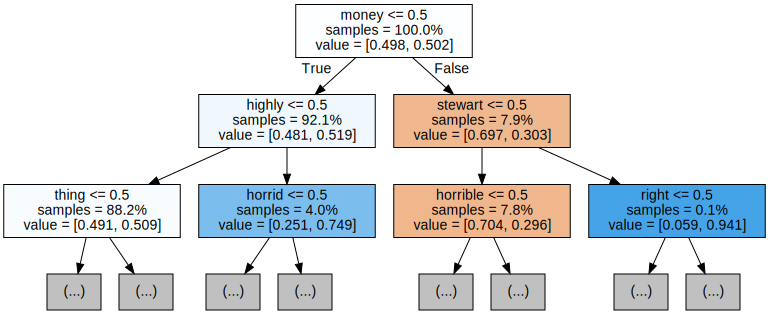

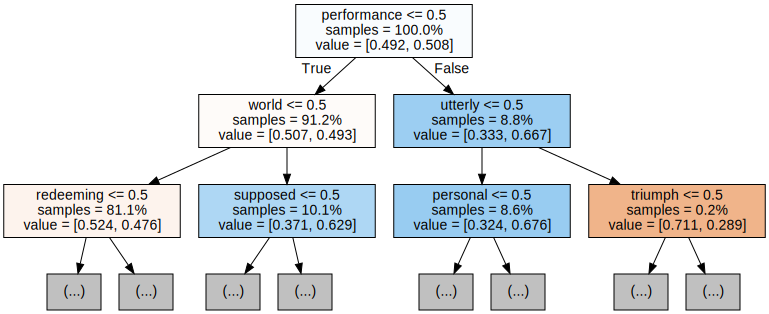

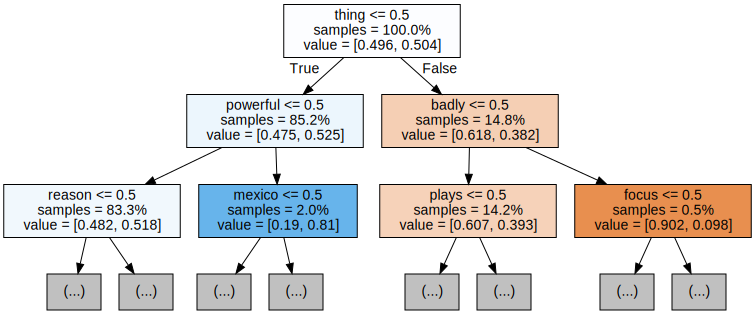

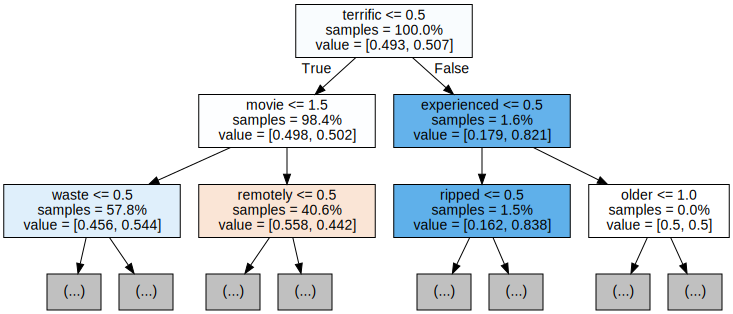

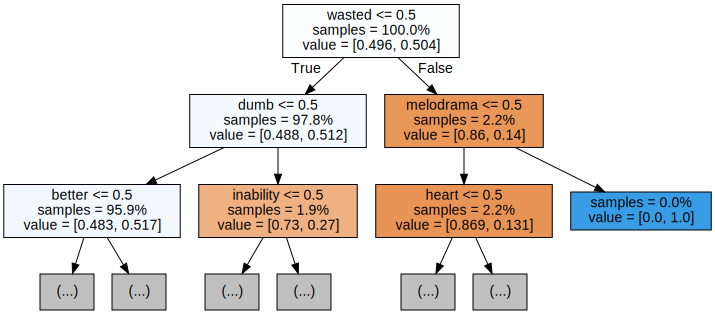

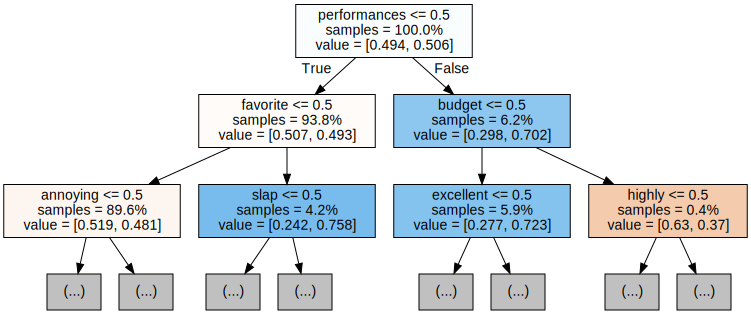

In [14]:
 # visualize decision tree from classifier
for i in range(10):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=vocab,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [15]:
print(preds_rf[0]) #first prediction for test item - model predicted positive sentiment
print(test_feat[0]) #first test review
print(clean_test_reviews[0])
print(type(y_test))
print(y_test.iloc[0])

1
[0 0 0 ... 0 0 0]
caught tail end movie channel surfing cable movie channels intrigued sought next showing really know expect reading program summary came away movie feeling quite disturbed distressed also gave adult attended high school little better insight kids contend days fact see shooting adds chillness plot see child adult alike struggle comprehend come terms senseless shootings times overwhelming admit shed quite tears throughout whole movie would seek however sure glad see
<class 'pandas.core.series.Series'>
1


In [16]:
# Are bigrams better or worse features compared to Bag of Words? Make a prediction.
# https://www.pythonprogramming.in/use-sklearn-countvectorize-vocabulary-specification-with-bigrams.html

# your code here

# Is the performance better or worse?

# Why do you think that is?

# Part II: Multilayer Perceptron

In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
print("Training MLP classifier... this may take some time")
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,),random_state=1, max_iter=300, verbose=True).fit(train_feat, y_train)
print("Done!")

Training MLP classifier... this may take some time
Iteration 1, loss = 0.37707421
Iteration 2, loss = 0.22708880
Iteration 3, loss = 0.18136650
Iteration 4, loss = 0.14803395
Iteration 5, loss = 0.12233833
Iteration 6, loss = 0.09659110
Iteration 7, loss = 0.07312707
Iteration 8, loss = 0.05465470
Iteration 9, loss = 0.04023628
Iteration 10, loss = 0.02877837
Iteration 11, loss = 0.02083346
Iteration 12, loss = 0.01554197
Iteration 13, loss = 0.01211603
Iteration 14, loss = 0.00944612
Iteration 15, loss = 0.00765647
Iteration 16, loss = 0.00632789
Iteration 17, loss = 0.00530490
Iteration 18, loss = 0.00452892
Iteration 19, loss = 0.00391752
Iteration 20, loss = 0.00341305
Iteration 21, loss = 0.00300726
Iteration 22, loss = 0.00268428
Iteration 23, loss = 0.00240332
Iteration 24, loss = 0.00217559
Iteration 25, loss = 0.00197445
Iteration 26, loss = 0.00180923
Iteration 27, loss = 0.00166337
Iteration 28, loss = 0.00154012
Iteration 29, loss = 0.00143164
Iteration 30, loss = 0.0013380

In [18]:
accuracy = mlp_clf.score(test_feat, y_test)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.8582


In [19]:
mlp_clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 300,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': True,
 'warm_start': False}

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
print("Training deeper MLP classifier... this may take some time")
mlp_clf_deeper = MLPClassifier(hidden_layer_sizes=(500,250,500,),random_state=1, max_iter=300, verbose=True).fit(train_feat, y_train)
print("Done!")

Training deeper MLP classifier... this may take some time
Iteration 1, loss = 0.35729842
Iteration 2, loss = 0.13317465
Iteration 3, loss = 0.02873186
Iteration 4, loss = 0.00951003
Iteration 5, loss = 0.00465321
Iteration 6, loss = 0.00967133
Iteration 7, loss = 0.00741889
Iteration 8, loss = 0.00553138
Iteration 9, loss = 0.00480113
Iteration 10, loss = 0.01045424
Iteration 11, loss = 0.01006270
Iteration 12, loss = 0.00310933
Iteration 13, loss = 0.00304105
Iteration 14, loss = 0.00170404
Iteration 15, loss = 0.00091515
Iteration 16, loss = 0.00086136
Iteration 17, loss = 0.00085454
Iteration 18, loss = 0.00084964
Iteration 19, loss = 0.00084543


In [ ]:
accuracy = mlp_clf_deeper.score(test_feat, y_test)
print("Accuracy: {}".format(accuracy))

In [ ]:
# Bias Variance tradeoff in ML theory holds that system error is a combination of bias, variance, and irreducible error
# According to this theory, reducing bias increase variance, which can lead to poor generalization.
# On the other hand, reducing variance increases bias, which can lead to poor model fit to training data.
# A number of techniques are used to balance bias and variance, including increasing/decreasing number of parameters, randomly ignoring parts of the parameter space during training, and others.
